# Team 11: Predicting the Impact of Twitter Posts on Bitcoin Prices

**Group Members:**  Andrey Bartashevich (14586517), Finn Prins (13458434), Duco Trompert (14591227)

**Research Question:** Can Twitter (a.k.a. X) posts of famous people influence the prices of Bitcoin?

# Hypothesis: 
**Null hypothesis:** There is no impact of Twitter  posts by individuals with over one million followers on the Bitcoin price movements.

**Alternative Hypothesis:** There is an impact of Twitter posts by individuals with over one million followers on the Bitcoin price movements


**Potentialy change the 1 mill foloowers with 250 000 followers, because the dataset doesnt have enough values for users with 1 000 000 followers.**

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from langdetect import DetectorFactory

**Data Processing**

Bitcoin dataset

In [2]:
# First btc price is 2012-01-01
# Last btc price is 2024-11-28

# First tweet is 2007-04-19
# Last tweet is 2019-11-23

# Data from 2012-01-01 to 2019-11-23 is valuable

# Date interval
start_day = "2012-01-01"
end_day = "2019-11-23"


# Open bitcoin csv
bitcoin = pd.read_csv('data/btcusd_1-min_data.csv')
# Renaming timestamp, Close, and Volume columns
bitcoin.rename(columns={'Timestamp': 'date', 'Close': 'price', 'Volume': 'volume'}, inplace=True)
# Convert to datetime and filter by date interval
bitcoin['date'] = pd.to_datetime(bitcoin['date'], unit='s')
bitcoin = bitcoin[(bitcoin['date'] >= start_day) & (bitcoin['date'] <= end_day)]
# Convert to daily granularity
bitcoin['date'] = bitcoin['date'].dt.date
bitcoin = bitcoin.groupby('date').agg(
    first_price=('price', 'first'),  # First price of the day
    last_price=('price', 'last'),   # Last price of the day
    price=('price', 'last'),   # Last closing price of the day
    volume=('volume', 'sum')   # Total daily volume
).reset_index()
bitcoin['change'] = bitcoin['last_price'] - bitcoin['first_price']
bitcoin['change'] = bitcoin['change'].fillna(0)
bitcoin = bitcoin[['date', 'price', 'change', 'volume']]


# Print processed Bitcoin data
print(f"Length: {len(bitcoin)}")
print(bitcoin.head())

Length: 2884
         date  price  change      volume
0  2012-01-01   4.84    0.26   10.000000
1  2012-01-02   5.00    0.16   10.100000
2  2012-01-03   5.29    0.29  107.085281
3  2012-01-04   5.57    0.28  107.233260
4  2012-01-05   6.42    0.85   70.328742


Twitter dataset

In [3]:
# Open twitter csv
tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')
# Rename timestamp and text\r columns
tweet.rename(columns={'timestamp': 'date', 'text\r': 'text'}, inplace=True)
# Convert to datetime and filter by date interval
tweet['date'] = pd.to_datetime(tweet['date']).dt.tz_localize(None)
tweet = tweet[(tweet['date'] >= start_day) & (tweet['date'] <= end_day)]
# Convert to daily granularity
tweet['date'] = tweet['date'].dt.date
# Drop unnecessary columns
tweet = tweet[['date', 'likes', 'replies', 'retweets', 'text']]

# Print processed Twitter data
print(f"Length: {len(tweet)}")
print(tweet.head())

/tmp/ipykernel_73599/329435101.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')


Length: 16853515
         date  likes  replies  retweets  \
0  2019-05-27      0        0         0   
1  2019-05-27      0        0         0   
2  2019-05-27      2        0         1   
3  2019-05-27      0        0         0   
4  2019-05-27      0        0         0   

                                                text  
0  È appena uscito un nuovo video! LES CRYPTOMONN...  
1  Cardano: Digitize Currencies; EOS https://t.co...  
2  Another Test tweet that wasn't caught in the s...  
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...  
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...  


Normalized total impressions calculation

In [4]:
impressions = tweet.groupby('date').agg(
    likes=('likes', 'sum'),  # Sum of likes per day
    replies=('replies', 'sum'),  # Sum of replies per day
    retweets=('retweets', 'sum'),  # Sum of retweets per day
).reset_index()
# Calculate average likes, replies and retweets
avg_likes = tweet['likes'].mean()
avg_replies = tweet['replies'].mean()
avg_retweets = tweet['retweets'].mean()
# Print average likes, replies and retweets
print(f"Average likes: {avg_likes}")
print(f"Average replies: {avg_replies}")
print(f"Average retweets: {avg_retweets}")
# Add normalized total impressions
impressions['total'] = 1 / avg_likes * impressions['likes'] + \
                             1 / avg_replies * impressions['replies'] + \
                             1 / avg_retweets * impressions['retweets']

print(f"Length: {len(impressions)}")
print(impressions.head())

Average likes: 2.66385540345738
Average replies: 0.3142164112352824
Average retweets: 1.049500000445011
Length: 2884
         date  likes  replies  retweets     total
0  2012-01-01      2        0         1  1.703626
1  2012-01-02      0        0         0  0.000000
2  2012-01-03      0        0         0  0.000000
3  2012-01-04      0        2         0  6.365040
4  2012-01-05      0        0         0  0.000000


**Filter only english tweets and sentiment analysis**

In [5]:
# Set seed for consistency of results
DetectorFactory.seed = 0


# Detection of english tweets amoung tweets
def is_english(text):
    try:
        # Check if the line is Nan or empty
        if pd.isna(text) or text.strip() == '':
            return False
        # Using detect function to find english text
        return detect(text) == 'en'
    except:
         return False


# Sentiment analysis using vader library
def vader_sentiment(text):
        # Starting vader module for text analysis
        analyzer = SentimentIntensityAnalyzer()
        # Geting sentiment scores on a scale from -1 to 1 as a dictionary (compound)
        scores = analyzer.polarity_scores(text)
        # Calcualting the sentiment of each text based on the compund score
        # Positive
        if scores['compound'] >= 0.05:
            sentiment = 1
        # Negative
        elif scores['compound'] <= -0.05:
            sentiment = -1
        # Neutral
        else:
            sentiment = 0

        return {'sentiment':sentiment, 'compound':scores['compound']}

**Data visualization**

/home/duco/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


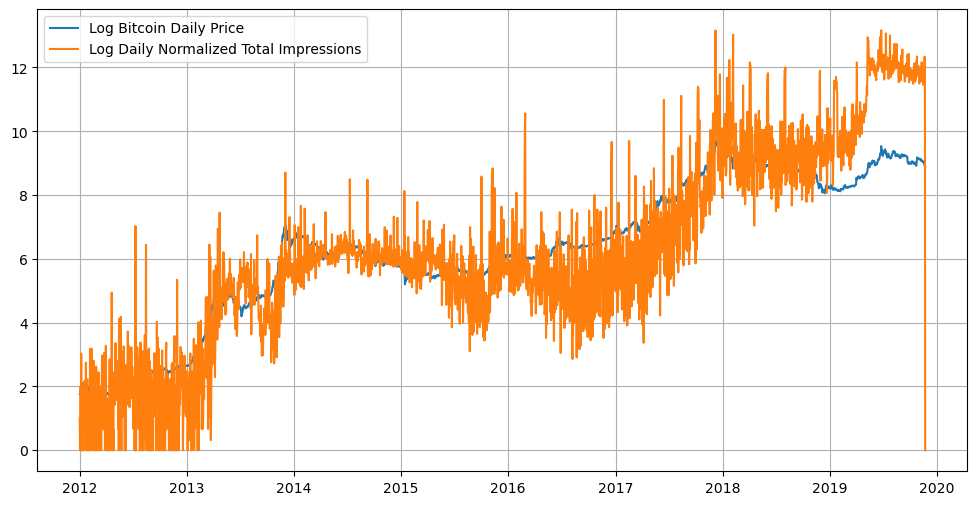

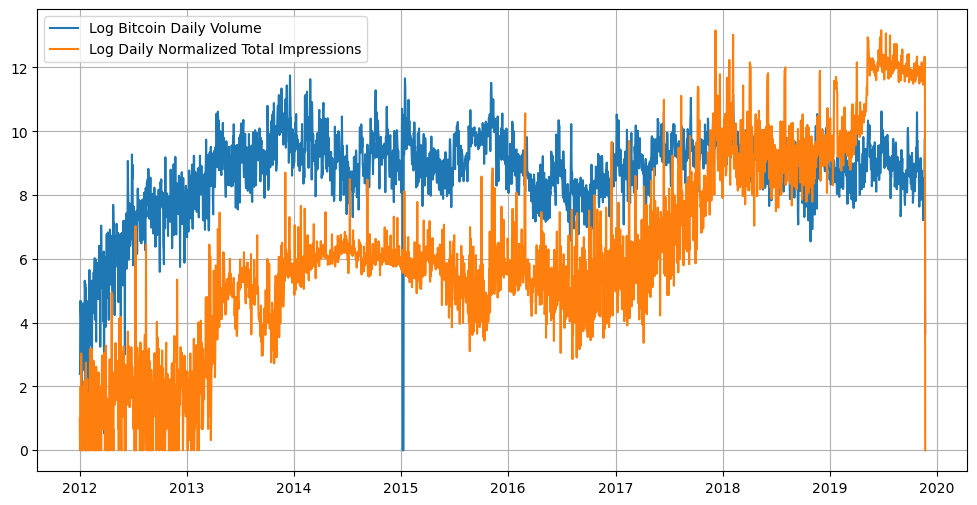

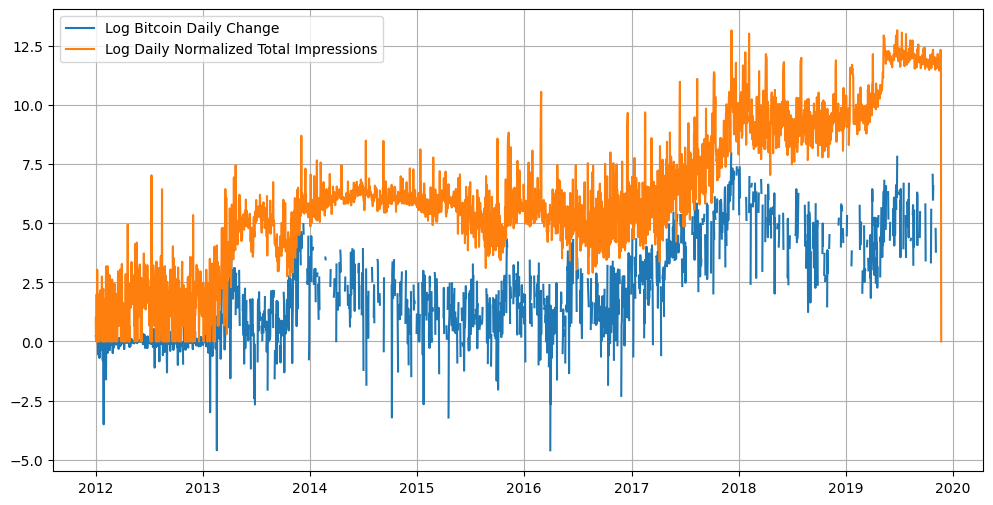

In [6]:
date_range = pd.date_range(start=start_day, end=end_day)
date_df = pd.DataFrame({'date': date_range.date})
date_df['date'] = pd.to_datetime(date_df['date'])

impressions['date'] = pd.to_datetime(impressions['date'])
impressions = pd.merge(date_df, impressions, on='date', how='left')
impressions = impressions.fillna(0)

bitcoin['date'] = pd.to_datetime(bitcoin['date'])
bitcoin = pd.merge(date_df, bitcoin, on='date', how='left')
bitcoin = bitcoin.fillna(0)


log_price = np.log(bitcoin['price'] + 1)           # Adding 1 to avoid log(0)
log_volume = np.log(bitcoin['volume'] + 1)         # Adding 1 to avoid log(0)
log_change = np.log(bitcoin['change'] + 1)         # Adding 1 to avoid log(0)
log_impressions = np.log(impressions['total'] + 1) # Adding 1 to avoid log(0)


# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['price'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_price, label='Log Bitcoin Daily Price')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['volume'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_volume, label='Log Bitcoin Daily Volume')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['change'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_change, label='Log Bitcoin Daily Change')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()

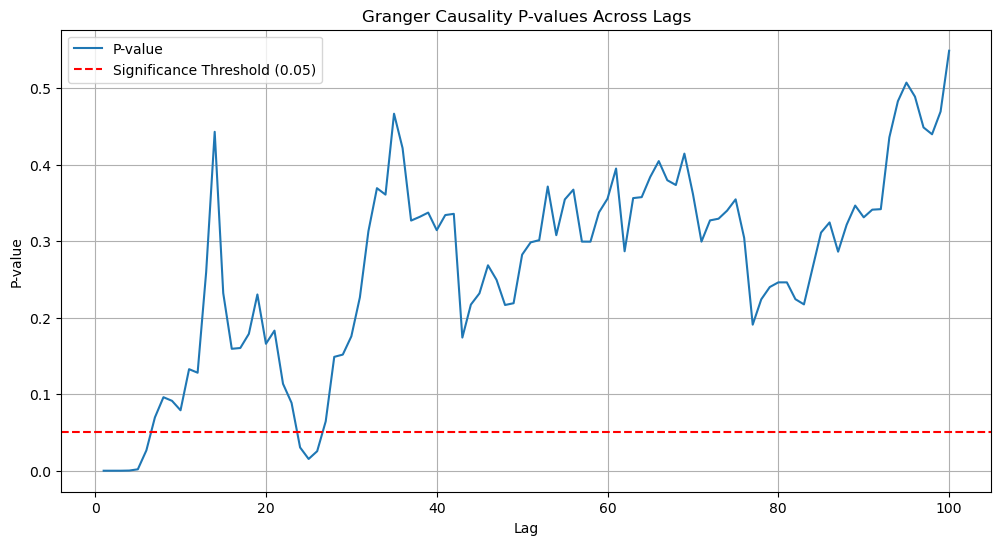

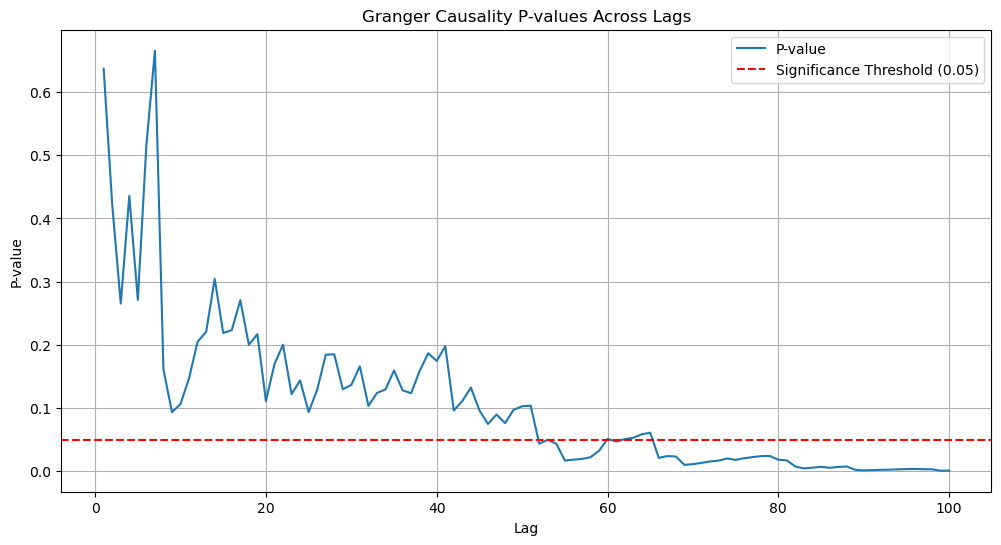

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

lag = 100

results = grangercausalitytests(pd.concat([log_volume, log_impressions], axis=1), maxlag=lag, verbose=False)

p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values Across Lags')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_price, log_impressions], axis=1), maxlag=lag, verbose=False)

p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values Across Lags')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

**Pearson correlation coefficient**

The Pearson correlation coefficient (denoted as $r$) is calculated as:

$r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}$

Where:
- $\text{Cov}(X, Y)$ is the covariance between $X$ and $Y$, which measures how much the two variables change together.
- $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, which measure the variability in each variable.

The value of $r$ lies between $-1$ and $1$:
- $r = 1$ shows a perfect positive linear correlation.
- $r = -1$ shows a perfect negative linear correlation.
- $r = 0$ shows no linear correaltion.

In [8]:
# Calculate mean
def calculate_mean(X):
    return sum(X) / len(X)


# Calculate standard deviation
def calculate_std(X):
    n = len(X)
    mean = calculate_mean(X)

    squared_differences = [(x - mean) ** 2 for x in X]

    variance = sum(squared_differences) / n

    std_dev = variance ** 0.5

    return std_dev


# Calculate covariance
def calculate_cov(X, Y):
    mean_x = calculate_mean(X)
    mean_y = calculate_mean(Y)

    deviations_product = [(x - mean_x) * (y - mean_y) for x, y in zip(X, Y)]

    covariance = sum(deviations_product) / len(X)

    return covariance


# Calculate Pearson correlation coefficient
def calculate_pcc(X, Y):
    covariance_XY = calculate_cov(X, Y)
    std_X = calculate_std(X)
    std_Y = calculate_std(Y)
    return covariance_XY / (std_X * std_Y)


# Calculate and print several Pearson correlation coefficients
pcc = calculate_pcc(log_price, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin prices and the logarithm of normalized total impressions is:\n{pcc}")

pcc = calculate_pcc(log_volume, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{pcc}")

pcc = calculate_pcc(log_change, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:\n{pcc}")

The Pearson correlation coefficient between the logarithm of Bitcoin prices and the logarithm of normalized total impressions is:
0.8968751750195144
The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:
0.43536160840694843
The Pearson correlation coefficient between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:
nan
